# Import required dependencies

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

import numpy as np
import numpy.random as random
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline

# Define constants
It is usually a good idea to have common constants defined up top, so we can easily change them as needed

In [4]:
UNK_TOKEN = '__unk__'
MAX_SEQUENCE_LENGTH = 50
VOCAB_SIZE = 15000

# Read data

In [5]:
import csv

emotions = {
	"anger":0,
	"boredom":1,
	"empty":2,
	"enthusiasm":3,
	"fun":4,
	"happiness":5,
	"hate":6,
	"love":7,
	"neutral":8,
	"relief":9,
	"sadness":10,
	"surprise":11,
	"worry": 12
}

emotions_stats = {k: 0 for k in emotions}
data_lines = []
num_classes = len(emotions)
with open('data/sentiment/text_emotion.csv', newline='') as f:
    reader = csv.reader(f)
    for row_idx, row in enumerate(reader):
        # Ignore first row since its a header row in the dataset
        if row_idx == 0: continue
            
        # Append a tuple of (emotion_index, text)
        if row[1] in emotions:
            data_lines.append((emotions[row[1]],row[3]))
            emotions_stats[row[1]] += 1
print("Read %d lines"%(len(data_lines)))

Read 40000 lines


## Train/Dev/Test splits
To see if our model actually learns, we divide all of the data into these three splits (70-10-20 split for train-dev-test)

In [6]:
# Send random seed for reproducible results
random.seed(5)
random.shuffle(data_lines)

total_instances = len(data_lines)
num_train_instances = int(0.7 * total_instances)
num_dev_instances = int(0.1 * total_instances)
num_test_instances = int(0.2 * total_instances)

train = data_lines[:num_train_instances]
dev = data_lines[num_train_instances:num_train_instances + num_dev_instances]
test = data_lines[num_train_instances + num_dev_instances:num_train_instances + num_dev_instances + num_test_instances]

## Preprocessing 

In [7]:
# Separate out labels and data
def get_data_labels(lines):
    labels, data = [], []
    for line in lines:
        l, d = line
        labels.append(int(l))
        data.append(d)
    
    return labels, data

train_labels, train_data = get_data_labels(train)
dev_labels, dev_data = get_data_labels(dev)
test_labels, test_data = get_data_labels(test)
print(train_labels[:10])
print(train_data[:10])

[8, 3, 12, 4, 12, 8, 6, 12, 8, 12]
["@psymon_spark heheh.  Odd though, I thought a couple of the others I'd done were better", "@jstueve Oh LOL! Yes, on Facebook! That's a nice safe environment. Like a church basement!", 'throat is reallyyyyy sore , i can barely talk', "@CeeCeeJayez episode 17 season 1, i love chuck bass.  who's going to the short stack filming next sat? Im making a flag. ;D", "Decided not to go...I want to see my sweetie  But I can't.", '@DJ71 they are all over one is a fan with a vip and the other one is the winner of the twisted vid  het si weer eens raar gelopen, chaos', 'IS ANYONE AWAKE?!?!?!?! oh my god i am dying here. i want to go to SLEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEP. :[', 'I am trying to upload my background from twitbacks. its not working', 'Just learned aobut #starwarsday. Thus: &quot;There are only 3 movies and Han Solo shot first&quot;. Deal with it', 'Cat is anxiously watching wild turkeys in my back yard....I think they have 

In [8]:
# Preprocess data
def preprocess(data):
    # Tokenize (separate by space, punctuation etc) and lowercase all data
    return [word_tokenize(t.lower()) for t in data]

train_data = preprocess(train_data)
dev_data = preprocess(dev_data)
test_data = preprocess(test_data)
print(train_data[:10])

[['@', 'psymon_spark', 'heheh', '.', 'odd', 'though', ',', 'i', 'thought', 'a', 'couple', 'of', 'the', 'others', 'i', "'d", 'done', 'were', 'better'], ['@', 'jstueve', 'oh', 'lol', '!', 'yes', ',', 'on', 'facebook', '!', 'that', "'s", 'a', 'nice', 'safe', 'environment', '.', 'like', 'a', 'church', 'basement', '!'], ['throat', 'is', 'reallyyyyy', 'sore', ',', 'i', 'can', 'barely', 'talk'], ['@', 'ceeceejayez', 'episode', '17', 'season', '1', ',', 'i', 'love', 'chuck', 'bass', '.', 'who', "'s", 'going', 'to', 'the', 'short', 'stack', 'filming', 'next', 'sat', '?', 'im', 'making', 'a', 'flag', '.', ';', 'd'], ['decided', 'not', 'to', 'go', '...', 'i', 'want', 'to', 'see', 'my', 'sweetie', 'but', 'i', 'ca', "n't", '.'], ['@', 'dj71', 'they', 'are', 'all', 'over', 'one', 'is', 'a', 'fan', 'with', 'a', 'vip', 'and', 'the', 'other', 'one', 'is', 'the', 'winner', 'of', 'the', 'twisted', 'vid', 'het', 'si', 'weer', 'eens', 'raar', 'gelopen', ',', 'chaos'], ['is', 'anyone', 'awake', '?', '!', '?

## Create vocabulary

In [9]:
# Prepare vocabulary
full_vocab = dict()
for instance in train_data:
    for token in instance:
        full_vocab[token] = 1 + full_vocab.get(token, 0)

# Sort vocabulary by occurence
sorted_vocab = sorted(full_vocab.keys(), key=lambda word: -full_vocab[word])

# Print some samples
print("Vocabulary size: %d"%(len(sorted_vocab)))
print("Most frequent tokens")
for i in range(10):
    print("\t%s: %d"%(sorted_vocab[i], full_vocab[sorted_vocab[i]]))
print("Least frequent tokens")
for i in range(1,11):
    print("\t%s: %d"%(sorted_vocab[-i], full_vocab[sorted_vocab[-i]]))

# We can choose to limit the vocab_size here to only a portion of the original vocab,
# i.e. ignore infrequent tokens to save on memory
vocab_size = VOCAB_SIZE
    
# Create final vocab
word2idx = {w: idx for idx, w in enumerate(sorted_vocab[:vocab_size])}
idx2word = {idx: w for idx, w in enumerate(sorted_vocab[:vocab_size])}


word2idx[UNK_TOKEN] = vocab_size
idx2word[vocab_size] = UNK_TOKEN
vocab_size = vocab_size + 1

Vocabulary size: 40857
Most frequent tokens
	i: 16568
	!: 15425
	.: 14265
	@: 14210
	to: 9997
	the: 9006
	,: 8445
	a: 6818
	my: 5569
	you: 5395
Least frequent tokens
	bruceocz: 1
	davidbaillie: 1
	hard..: 1
	cute..oh: 1
	tiaratara123: 1
	daniels: 1
	stephenrlee: 1
	insonmia: 1
	forgottten: 1
	existes: 1


## Filter text based on vocabulary
We will now have to replace words we do not have in the vocabulary with a special token, `__unk__` in this case

In [10]:
train_data = [[t if t in word2idx else UNK_TOKEN for t in instance] for instance in train_data]
dev_data = [[t if t in word2idx else UNK_TOKEN for t in instance] for instance in dev_data]
test_data = [[t if t in word2idx else UNK_TOKEN for t in instance] for instance in test_data]

print("Number of tokens filtered out as unknown:")
print("Train: %d/%d"%(len([1 for instance in train_data for t in instance if t == UNK_TOKEN]), sum([len(i) for i in train_data])))
print("Dev: %d/%d"%(len([1 for instance in dev_data for t in instance if t == UNK_TOKEN]), sum([len(i) for i in dev_data])))
print("Test: %d/%d"%(len([1 for instance in test_data for t in instance if t == UNK_TOKEN]), sum([len(i) for i in test_data])))

Number of tokens filtered out as unknown:
Train: 25857/456373
Dev: 5369/65997
Test: 10660/132329


# Prepare data in tensor form
Our keras models finally take tensors as input and labels, so we need to modify our data to fit this form

In [11]:
## data_to_tensor
# Given a list of instances, where each instance is a list of tokens,
# this function does the following:
# 1: Replace each token with its corresponding index
# 2: Pad sequences to MAX_SEQUENCE_LENGTH (or truncate them if longer)
#       Padding is done with a unique element, in this case `vocab_size`
#       The network will learn that this unique element is padding and does not
#        mean anything semantically
# 3: Package everything nicely as a NUM_INSTANCES x MAX_SEQUENCE_LENGTH matrix
def data_to_tensor(data):
    # First convert from words to indices
    idx_data = [[word2idx[t] for t in instance] for instance in data]
    
    # Create numpy representation
    return pad_sequences([np.array(d) for d in idx_data], maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value=vocab_size)

X_train = data_to_tensor(train_data)
y_train = to_categorical(np.array(train_labels, dtype=np.int))

X_dev = data_to_tensor(dev_data)
y_dev = to_categorical(np.array(dev_labels, dtype=np.int))

X_test = data_to_tensor(test_data)
y_test = to_categorical(np.array(test_labels, dtype=np.int))

vocab_size = vocab_size + 1 # Add 1 for the padding token

In [12]:
def idx_to_bow(data):
    data_bow = np.zeros((data.shape[0], vocab_size)) 
    for i in range(data.shape[1]):
        data_bow[np.arange(data.shape[0]), data[:, i]] = 1
    return data_bow

X_train_bow = idx_to_bow(X_train)
X_dev_bow = idx_to_bow(X_dev)
X_test_bow = idx_to_bow(X_test)

# Model Definition

In [13]:
model = Sequential()
model.add(Dense(25, input_shape=(vocab_size,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(emotions)))
model.add(Softmax())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_560.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                375075    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                663       
_________________________________________________________________
softmax_1 (Softmax)          (None, 13)                0         
Total params: 383,388
Trainable params: 383,388
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train_bow, y_train, epochs=10, validation_data=(X_dev_bow, y_dev))

Train on 28000 samples, validate on 4000 samples
Epoch 1/10
28000/28000 [==============================] - 27s 972us/step - loss: 1.9975 - acc: 0.3168 - val_loss: 1.8645 - val_acc: 0.3665
Epoch 2/10
28000/28000 [==============================] - 25s 900us/step - loss: 1.6822 - acc: 0.4341 - val_loss: 1.8950 - val_acc: 0.3620
Epoch 3/10
28000/28000 [==============================] - 23s 815us/step - loss: 1.3564 - acc: 0.5504 - val_loss: 2.0726 - val_acc: 0.3483
Epoch 4/10
28000/28000 [==============================] - 23s 807us/step - loss: 1.0364 - acc: 0.6593 - val_loss: 2.3753 - val_acc: 0.3152
Epoch 5/10
28000/28000 [==============================] - 22s 781us/step - loss: 0.7964 - acc: 0.7405 - val_loss: 2.7789 - val_acc: 0.3225
Epoch 6/10
28000/28000 [==============================] - 22s 803us/step - loss: 0.6231 - acc: 0.8023 - val_loss: 3.1363 - val_acc: 0.2903
Epoch 7/10
28000/28000 [==============================] - 23s 821us/step - loss: 0.5079 - acc: 0.8382 - val_loss: 3.6

In [15]:
test_loss, test_acc = model.evaluate(X_test_bow, y_test)
print("Test Set Accuracy: %0.2f%%"%(test_acc*100))

8000/8000 [==============================] - 6s 743us/step
Test Set Accuracy: 25.96%


([<matplotlib.axis.YTick at 0x1a12182e80>,
 <a list of 13 Text yticklabel objects>)

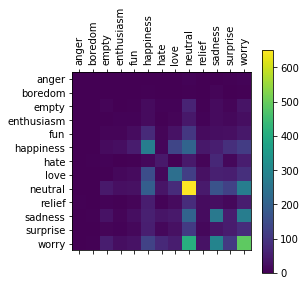

In [16]:
y_pred = model.predict(X_test_bow)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.matshow(cm)
plt.colorbar()

tick_marks = np.arange(len(emotions))
classes = sorted(emotions.keys(), key=lambda x: emotions[x])
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)